In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rc

In [2]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
sns.set_style('whitegrid')

In [32]:
df = pd.read_csv('beyond-training-window.csv')

In [33]:
model_names = {
    'qwen1p5': 'Qwen2.5-Coder-1.5B',
    'ocoder1p5_theta_500k': 'OpenCoder-1.5B-Base',
    'dseek1p3': 'DeepSeek-Coder-Base 1.3B',
}

def get_full_model_name(truncated_name: str, eval_name: str) -> str:
    full_name = model_names[truncated_name]

    if truncated_name == 'ocoder1p5_theta_500k':
        if eval_name.endswith('file_level_2'):
            full_name += '\nFile-Level composer'
        elif eval_name.endswith('filled_python_files_2'):
            full_name += '\nPath Distance composer'
        else:
            raise ValueError
    
    return full_name


def extract_context_size(eval_name: str) -> int:
    return int(eval_name.split('k_')[0].split('_')[-1])

In [34]:
df.model = df.apply(lambda x: get_full_model_name(x.model, x.eval_name), axis=1)
df['context_size'] = df.eval_name.apply(extract_context_size)
df.inproject_em *= 100
df.infile_em *= 100

In [35]:
line_type = 'inproject'  # inproject or infile
df = df.loc[:, ['model', 'context_size', f'{line_type}_em']]

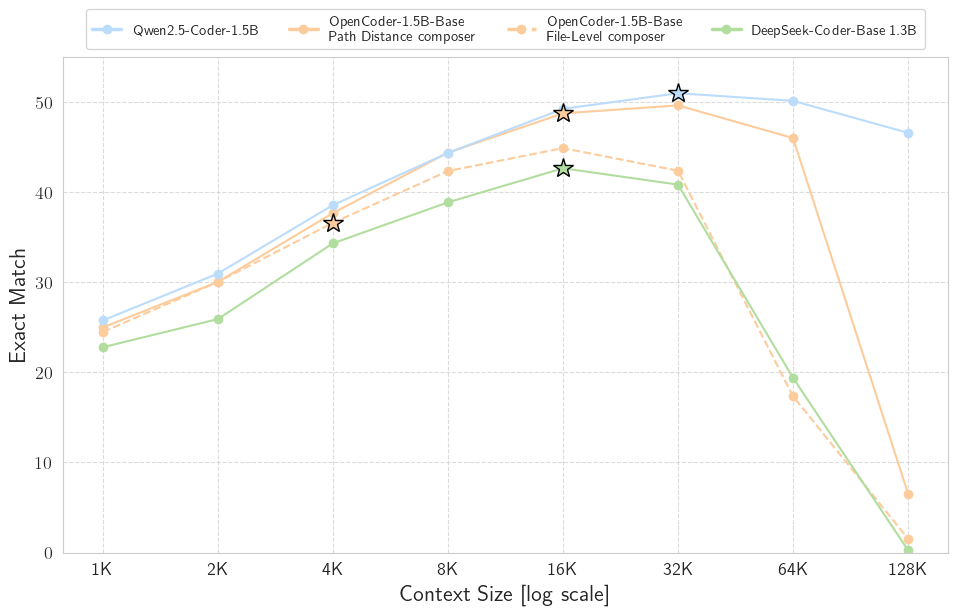

In [36]:
plt.figure(figsize=(10, 6.25))

context_sizes = [1, 2, 4, 8, 16, 32, 64, 128]

unique_models = df['model'].unique()

colors = {
    'DeepSeek-Coder-Base 1.3B': '#b1dd9f',
    'OpenCoder-1.5B-Base\nFile-Level composer': '#fccc9c',
    'OpenCoder-1.5B-Base\nPath Distance composer': '#fccc9c',
    'Qwen2.5-Coder-1.5B': '#bcdcfc',
}

line_styles = {
    'DeepSeek-Coder-Base 1.3B': '-',
    'OpenCoder-1.5B-Base\nFile-Level composer': '--',
    'OpenCoder-1.5B-Base\nPath Distance composer': '-',
    'Qwen2.5-Coder-1.5B': '-',
}

for i, model in enumerate(unique_models):
    model_data = df[df['model'] == model]
    plt.plot(model_data['context_size'], model_data[f'{line_type}_em'], 
             color=colors[model], marker='o', 
             linestyle=line_styles[model],
             label=model)

qwen_data = df[df['model'] == 'Qwen2.5-Coder-1.5B']
if len(qwen_data) > 5:
    plt.plot(qwen_data.iloc[5]['context_size'], qwen_data.iloc[5][f'{line_type}_em'], 
             marker='*', markersize=15, color=colors['Qwen2.5-Coder-1.5B'],
             markeredgecolor='black', markeredgewidth=1)

deepseek_data = df[df['model'] == 'DeepSeek-Coder-Base 1.3B']
if len(deepseek_data) > 4:
    plt.plot(deepseek_data.iloc[4]['context_size'], deepseek_data.iloc[4][f'{line_type}_em'], 
             marker='*', markersize=15, color=colors['DeepSeek-Coder-Base 1.3B'],
             markeredgecolor='black', markeredgewidth=1)

ocoder_fl_data = df[df['model'] == 'OpenCoder-1.5B-Base\nFile-Level composer']
if len(ocoder_fl_data) > 2:
    plt.plot(ocoder_fl_data.iloc[2]['context_size'], ocoder_fl_data.iloc[2][f'{line_type}_em'], 
             marker='*', markersize=15, color=colors['OpenCoder-1.5B-Base\nFile-Level composer'],
             markeredgecolor='black', markeredgewidth=1)

ocoder_pd_data = df[df['model'] == 'OpenCoder-1.5B-Base\nPath Distance composer']
if len(ocoder_pd_data) > 4:
    plt.plot(ocoder_pd_data.iloc[4]['context_size'], ocoder_pd_data.iloc[4][f'{line_type}_em'], 
             marker='*', markersize=15, color=colors['OpenCoder-1.5B-Base\nPath Distance composer'],
             markeredgecolor='black', markeredgewidth=1)

plt.xscale('log')
plt.xticks(context_sizes, [f'{size}K' for size in context_sizes], fontsize=13)
plt.xlabel('Context Size [log scale]', fontsize=16)

plt.ylabel('Exact Match', fontsize=16)
plt.ylim(0, 55)
plt.yticks(range(0, 55, 10), fontsize=13)
plt.grid(True, linestyle='--', alpha=0.7)

legend_order = [
    'Qwen2.5-Coder-1.5B',
    'OpenCoder-1.5B-Base\nPath Distance composer',
    'OpenCoder-1.5B-Base\nFile-Level composer',
    'DeepSeek-Coder-Base 1.3B',
]

from matplotlib.lines import Line2D

legend_line_styles = {
    'DeepSeek-Coder-Base 1.3B': '-',
    'OpenCoder-1.5B-Base\nFile-Level composer': (0, (5, 2)),
    'OpenCoder-1.5B-Base\nPath Distance composer': '-',
    'Qwen2.5-Coder-1.5B': '-',
}

custom_handles = []
for model in legend_order:
    if model in unique_models:
        line = Line2D(
            [0], [0],
            color=colors[model],
            marker='o',
            linestyle=legend_line_styles[model],
            markersize=6,
            linewidth=2.5,
            label=model
        )
        custom_handles.append(line)

plt.legend(
    handles=custom_handles,
    title='',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.11),
    ncol=len(legend_order),
    fontsize=10.5,
)

plt.tight_layout()

plt.savefig(f'beyond-training-window-{line_type}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'beyond-training-window-{line_type}.svg', format='svg', bbox_inches='tight')